In [2]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

Hasta ahora hemos ajustado el modelo usando una Regresión Logística, pero como hemos aprendido, podemos usar el Decision Tree en este tipo de problemas. Los objetivos de este pair programming :

- Ajustad un modelo de Decision Tree a nuestros datos.
- Calculad las métricas a nuestro nuevo modelo.
- Comparad las métricas con el modelo hecho hasta ahora. ¿Cuál es mejor?

In [3]:
df_esta = pd.read_csv("./datos/cortos_estand.csv", index_col = 0)
df_esta.head()

satisfaction  Customer Type  Seat comfort  Food and drink  \
0             1              1             0               0   
1             1              1             0               0   
2             1              1             0               0   
3             1              1             0               0   
4             1              1             0               0   

   Inflight entertainment  Ease of Online booking  On-board service  \
0                       4                       3                 3   
1                       2                       3                 4   
2                       0                       2                 3   
3                       4                       1                 1   
4                       3                       2                 2   

   Checkin service  Cleanliness  Online boarding   Age_est  \
0                5            3                2  1.676424   
1                2            3                2  0.486731   
2                4            4                2 -1.628279   
3                4            1                3  1.345954   
4                4            2                5  2.006895   

   Flight Distance_est  Gender_Female  Gender_Male  \
0            -1.758838              1            0   
1             0.583063              0            1   
2             0.235878              1            0   
3            -1.377574              1            0   
4            -1.664055              1            0   

   Type of Travel_Business travel  Type of Travel_Personal Travel  \
0                               0                               1   
1                               0                               1   
2                               0                               1   
3                               0                               1   
4                               0                               1   

   Class_Business  Class_Eco  Class_Eco Plus  
0               0          1               0  
1               1          0               0  
2               0          1               0  
3               0          1               0  
4               0          1               0

In [4]:
# separamos los datos en X e y

X1 = df_esta.drop("satisfaction", axis = 1)
y1 = df_esta["satisfaction"]

In [5]:
# separamos en train y test
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [6]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeClassifier(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train1, y_train1)

DecisionTreeClassifier(random_state=0)

In [7]:
#fig = plt.figure(figsize = (10,6))
#tree.plot_tree(arbol, feature_names = x_train1.columns, filled = True)
#plt.show()

In [8]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 4. 

max_features = np.sqrt(len(x_train1.columns))
max_features

4.242640687119285

In [9]:
# max depth
print(arbol.tree_.max_depth)

36


In [10]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_esta = arbol.predict(x_test1)
y_pred_train_esta = arbol.predict(x_train1)

In [11]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kapppa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [12]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test1, y_pred_test_esta, y_train1, y_pred_train_esta, "Decission Tree Esta I")
dt_results1

accuracy  precision    recall        f1    kapppa    set  \
0  0.920143   0.922581  0.931057  0.926799  0.838958   test   
1  1.000000   1.000000  1.000000  1.000000  1.000000  train   

                  modelo  
0  Decission Tree Esta I  
1  Decission Tree Esta I

In [13]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [6, 12, 18,24,30,36], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [14]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10,  
            verbose=-1) # para que no nos printee ningún mensaje en pantalla


In [15]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train1, y_train1)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [6, 12, 18, 24, 30, 36],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             verbose=-1)

In [16]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeClassifier(max_depth=36, max_features=3, min_samples_leaf=10,
                       min_samples_split=50, random_state=42)

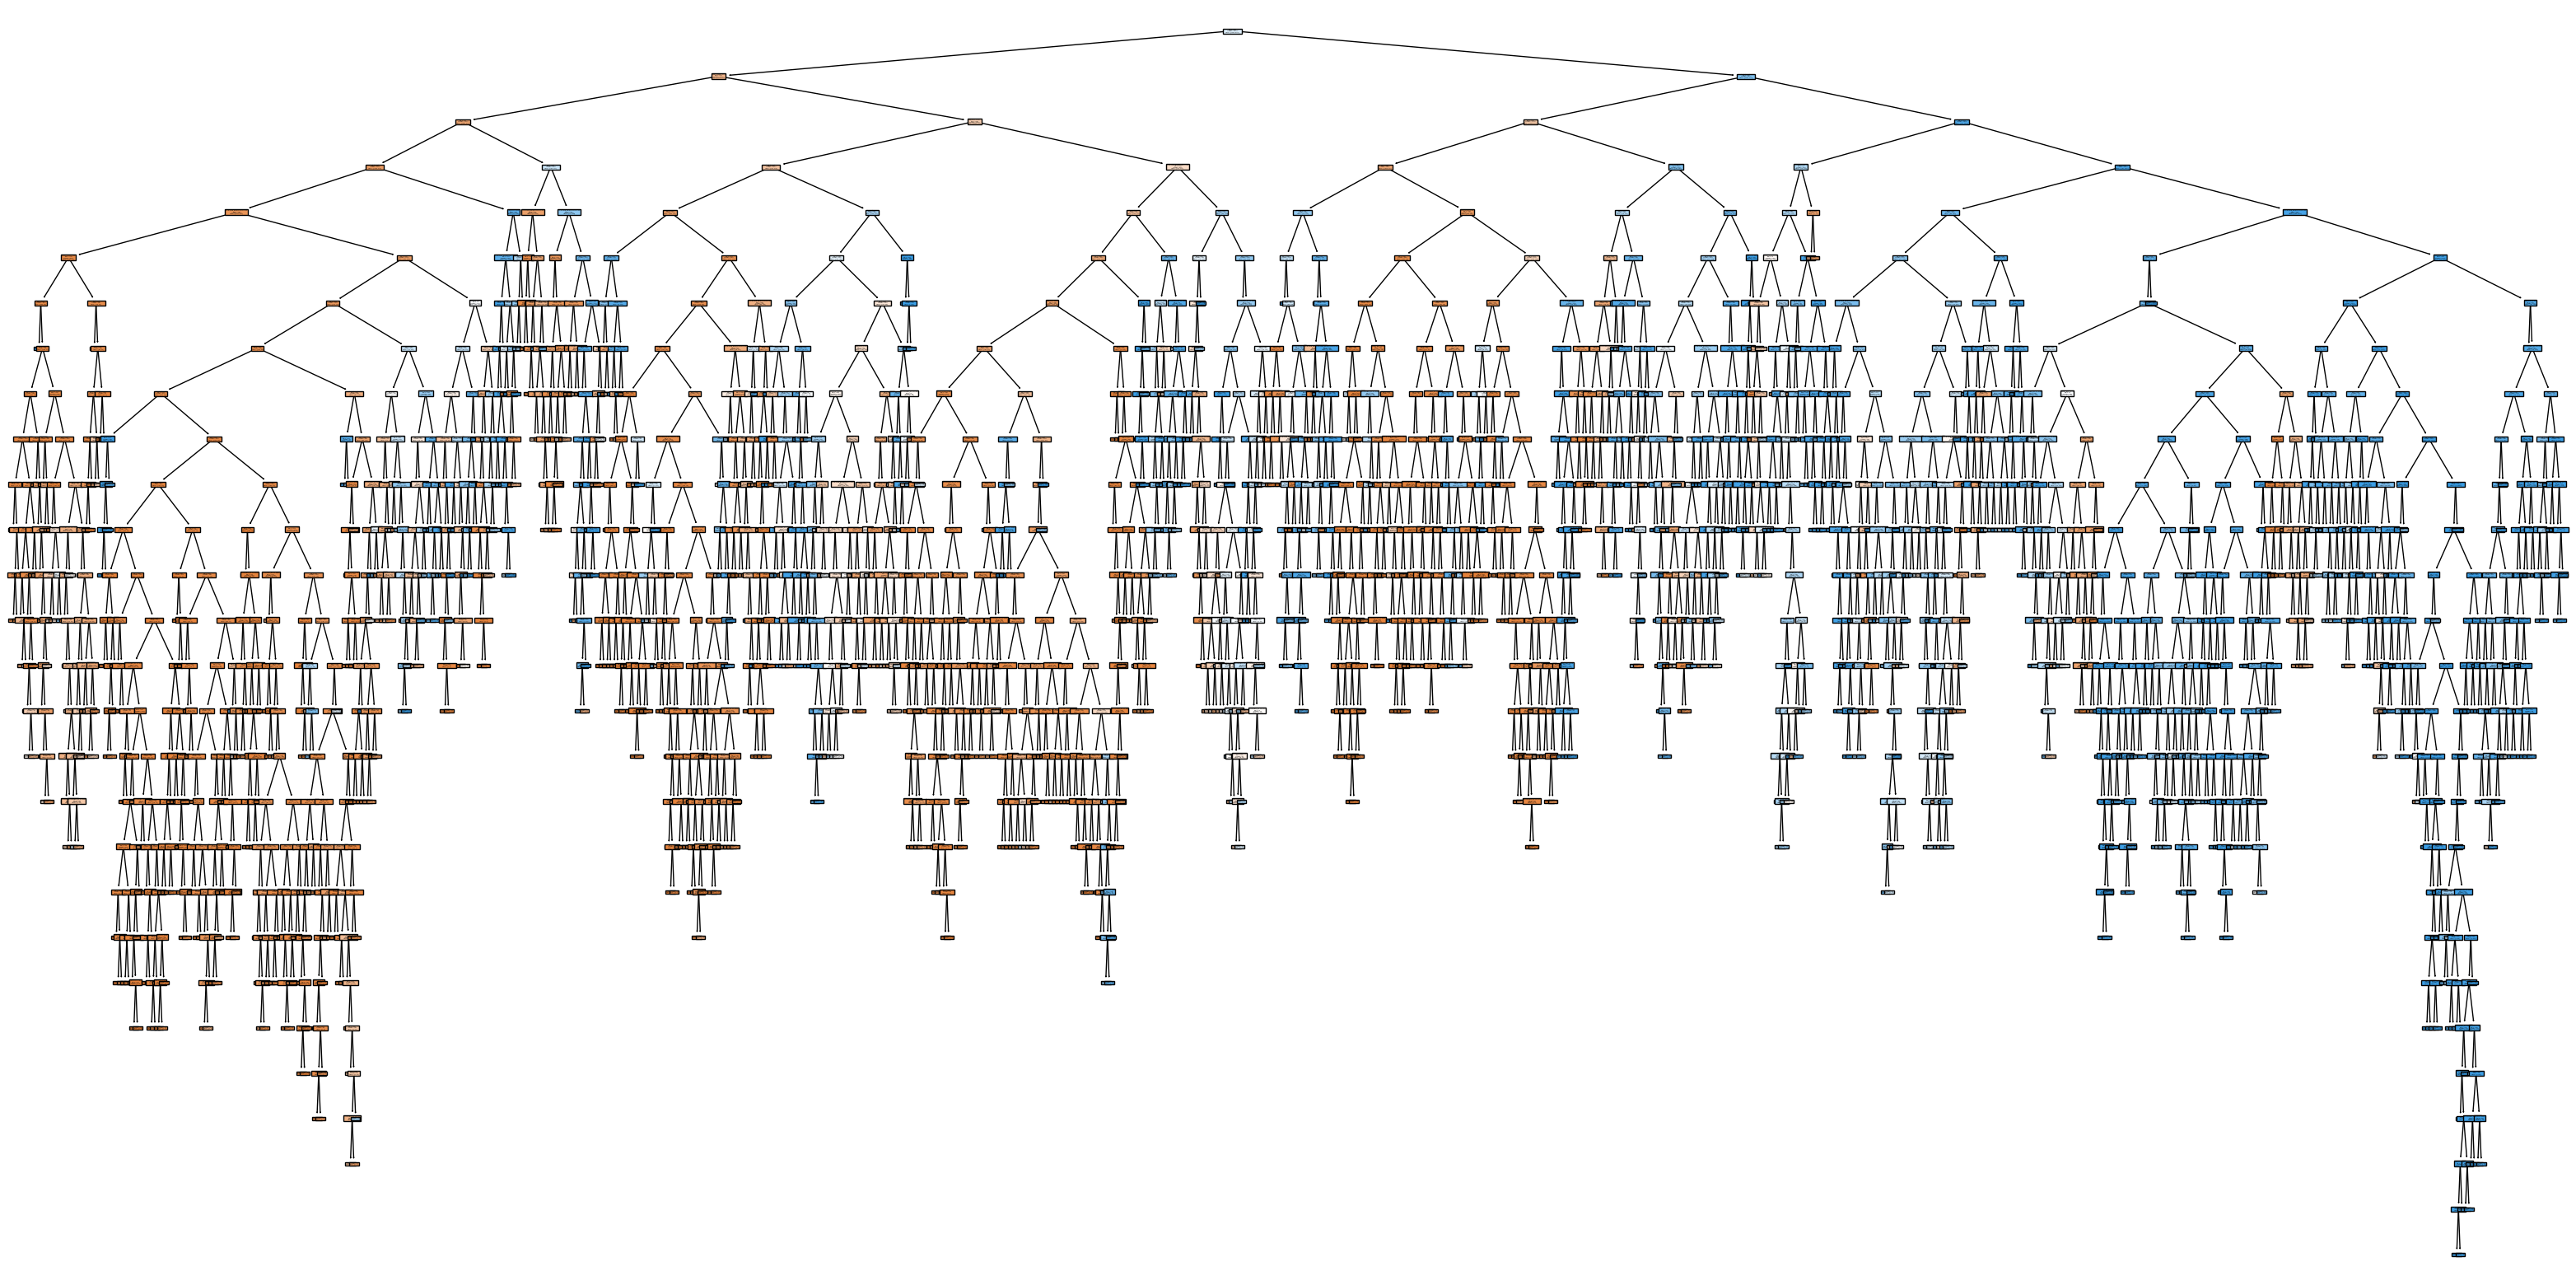

In [17]:
# veamos ahora que pinta tiene nuestro árbol

fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train1.columns, filled=True);

In [18]:
y_pred_test_esta2 = mejor_modelo.predict(x_test1)
y_pred_train_esta2 = mejor_modelo.predict(x_train1)

In [19]:
dt_results2 = metricas(y_test1, y_pred_test_esta2, y_train1,  y_pred_train_esta2, "Decision tree Esta II")
dt_results2

accuracy  precision    recall        f1    kapppa    set  \
0  0.918532   0.924427  0.925631  0.925029  0.835832   test   
1  0.926730   0.933443  0.932183  0.932812  0.852250  train   

                  modelo  
0  Decision tree Esta II  
1  Decision tree Esta II

In [20]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

accuracy  precision    recall        f1    kapppa    set  \
0  0.920143   0.922581  0.931057  0.926799  0.838958   test   
1  1.000000   1.000000  1.000000  1.000000  1.000000  train   
0  0.918532   0.924427  0.925631  0.925029  0.835832   test   
1  0.926730   0.933443  0.932183  0.932812  0.852250  train   

                  modelo  
0  Decission Tree Esta I  
1  Decission Tree Esta I  
0  Decision tree Esta II  
1  Decision tree Esta II

In [21]:
df_logistic_results = pd.read_csv("./datos/resultados_regresion.csv", index_col = 0)
df_logistic_results


accuracy  precision    recall        f1    kapppa    set  \
0  0.826970   0.836453  0.846922  0.841655  0.650954   test   
1  0.831502   0.843147  0.849157  0.846141  0.659930  train   

                modelo  
0  Regresión logistica  
1  Regresión logistica

In [22]:
# concatenamos todos los resultados

df_DT_LR_results = pd.concat([df_logistic_results, df_decision_results], axis = 0).reset_index(drop=True)
df_DT_LR_results

accuracy  precision    recall        f1    kapppa    set  \
0  0.826970   0.836453  0.846922  0.841655  0.650954   test   
1  0.831502   0.843147  0.849157  0.846141  0.659930  train   
2  0.920143   0.922581  0.931057  0.926799  0.838958   test   
3  1.000000   1.000000  1.000000  1.000000  1.000000  train   
4  0.918532   0.924427  0.925631  0.925029  0.835832   test   
5  0.926730   0.933443  0.932183  0.932812  0.852250  train   

                  modelo  
0    Regresión logistica  
1    Regresión logistica  
2  Decission Tree Esta I  
3  Decission Tree Esta I  
4  Decision tree Esta II  
5  Decision tree Esta II

En conclusión y como podemos observar nuestros segundo modelo de Decision Tree II es el que obtiene mejores resultados. Con un max depth de 36 y un max features de 3 como la mejor combinación de parámetros.

In [23]:
# vamos a crearnos un dataframe 
importancia_predictores_esta = pd.DataFrame(
                            {'predictor': x_train1.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores_esta.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores_esta


Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
3           Inflight entertainment     0.272302
4           Ease of Online booking     0.256108
1                     Seat comfort     0.146485
8                  Online boarding     0.061905
2                   Food and drink     0.043015
0                    Customer Type     0.037055
12                     Gender_Male     0.025907
6                  Checkin service     0.023919
13  Type of Travel_Business travel     0.019773
14  Type of Travel_Personal Travel     0.019416
15                  Class_Business     0.016452
11                   Gender_Female     0.016287
9                          Age_est     0.015059
7                      Cleanliness     0.014377
5                 On-board service     0.013085
10             Flight Distance_est     0.011845
16                       Class_Eco     0.005834
17                  Class_Eco Plus     0.001177

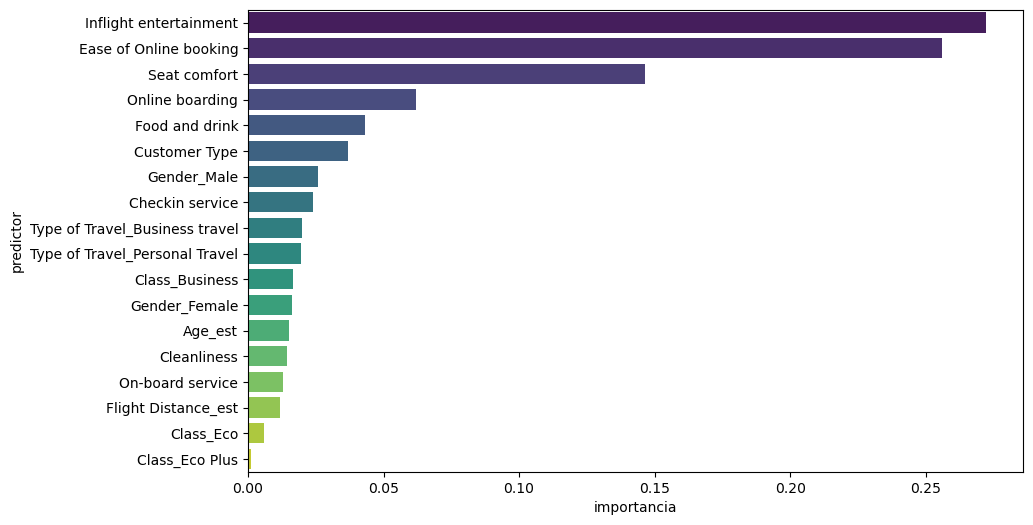

In [24]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores_esta, palette="viridis");
plt.show()

Con respecto a laa hipotesis que nos planteabamos el Customer Type no afecta directamente a la satisfacción de los pasajeros, tanto como los servicios de entretenimiento a bordo y la facilidad de hacer la reserva online.

Guardamos los resultados.

In [26]:
df_DT_LR_results.to_csv("./datos/resultados_tree_log.csv")